

---

# Task: Word Recognition

You have to train a deep CNN model that can help in recognising a word, i.e. given a word-image(image with a word present in it) as input, the model yields a representation that can help in recognising the word from a set of possible words (termed as  'lexicon' of words). 

---

## Representations of the word

There are two representations for a word:

1. **Alpha representation**: This is based on the claim that a word can be represented in terms of occurences of characters in various segments of image.

The word is split into equal parts at various levels.

At level *i*:  
* A word is split into *i* (nearly) equal segments.  
* For every segment, we compute a binary vector in which each segment correspond to alphabets/characters (Shown in fig.).

![Alpha Vector](https://drive.google.com/uc?export=view&id=17rUvYXvWUc2IP8aD-O3kualSjr2dcn2b)

*  Individual vectors of each segment are concatenated after one another, i.e. the level vector is obtained by concatenating individual vectors of first segment followed by second, third and so on.

The final vector is obtained by concatenating vectors of all levels $\{L_i.L_{i+1}.L_{i+2}\cdots\}$.


*For this assignment, you are supposed to use levels 2-5. 
This makes the length of final Alpha vector to be (2+3+4+5) * 26 = 364*



2. **Omega representation**: This is based on the claim that a word can be represented in terms of count of 11 primitve shapes present in various segments of image. The 11 shapes are: *ascender, descender, left small semi-circle, right small semi-circle, left large semi-circle, right large semi-circle, circle, vertical line, diagonal line, diagonal line at a slope of 135 degrees, and horizontal line*. These have been shown in figure.

![Primary Shapes](https://drive.google.com/uc?export=view&id=1573VBQwD03ae_UBjDaYk4fq84bGmDzr2)

The word is split into equal parts at various levels.

At level *i*:  
* A word is split into *i* (nearly) equal segments.  
* For every segment, we compute a vector in which each segment correspond to count of a shape.

![Omega for anagram](https://drive.google.com/uc?export=view&id=1nk1pj0yp5wunCxYeUp5ppH8hdsHF41rv)


*  Individual vectors of each segment are concatenated after one another, i.e. the level vector is obtained by concatenating individual vectors of first segment followed by second, third and so on.

The final vector is obtained by concatenating vectors of all levels $\{L_i.L_{i+1}.L_{i+2}\cdots\}$.

*For this assignment, you are supposed to use levels 1-5. 
This makes the length of final Omega vector to be (1+2+3+4+5) * 11 = 165*

---

**Note**: For both representations, while splitting, in case of unequal lengths of segments, segments at the end should be of more length e.g. Level 3 split of "omega" = {o,me,ga} and "play" = {p,l,ay}. Also, for a smaller words like "ok" level 3 split = {$\epsilon$,o,k} where $\epsilon$ = empty string. 

---

final goal of this assignment is to detemine which representation will be more helpful for word recognition. 



In [1]:
# Import the necessary libraries

import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import random
import sys
import csv
import statistics

# If using Google Colab, use the following package to display the image
# If running on your local system, cv2.imshow shall work fine
# If running on your local system please comment the line below
from google.colab.patches import cv2_imshow

In [2]:
IMG_HEIGHT = 50
IMG_WIDTH = 250

# Dataset

The dataset used here is a synthetic word recognition dataset. It consists of images of lowercase English words, generated with handwritten-fonts. All images are single channel (grayscale) and have size 250 * 50. <br>

The dataset has the following directory structure:

<pre>
<b>WR-Dataset</b>
|__ <b>train</b>: [foo_1.png, bar_2.png, sample_3.png ....]
|__ <b>validation</b>: [foo_221.png, bar_322.png, sample_353.png ....]
|__ <b>test</b>: [bar_521.png, foo_272.png, example_433.png ....]
|__ <b>Alphabet.csv</b>
    
</pre>

Extract the paths of these directories onto different variables to facilitate accessing the dataset and thereby training the model.

In [3]:
from google.colab import drive

drive.mount('/content/drive')
!ls drive/MyDrive/wr-dataset/WR-Dataset

Mounted at /content/drive
Alphabet.csv  Test  Train  Validation


In [4]:
#Add the paths for train, validation and test directories

train_dir_path="drive/MyDrive/wr-dataset/WR-Dataset/Train/"
validation_dir_path="drive/MyDrive/wr-dataset/WR-Dataset/Validation/"
test_dir_path="drive/MyDrive/wr-dataset/WR-Dataset/Test/"
csv_path = "drive/MyDrive/wr-dataset/WR-Dataset/Alphabet.csv"

# Visualizing sample images

Prepare an image to label map and visualize 5 randomly chosen images from training, validation and test sets (along with their labels). Also, Mention the number of word classes present in each of the three sets.

----

**(1+1+1) points**

---

dataframe for training set:
         Image Labels
0     no_0.png     no
1     no_1.png     no
2     no_3.png     no
3     no_4.png     no
4     no_6.png     no
...        ...    ...
2047  am_5.png     am
2048  am_7.png     am
2049  an_0.png     an
2050  an_1.png     an
2051  an_2.png     an

[2052 rows x 2 columns]

dataframe for validation set:
                Image      Labels
0             a_3.png           a
1           add_2.png         add
2         about_3.png       about
3       address_5.png     address
4       address_7.png     address
..                ...         ...
103  university_6.png  university
104        very_5.png        very
105         way_6.png         way
106     website_1.png     website
107       years_4.png       years

[108 rows x 2 columns]

dataframe for test set:
             Image   Labels
0      about_2.png    about
1    address_0.png  address
2    address_2.png  address
3    address_4.png  address
4      after_6.png    after
..             ...      ...

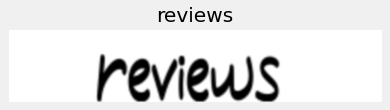

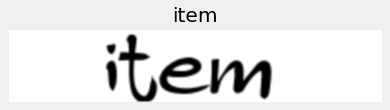

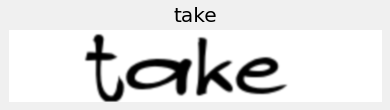

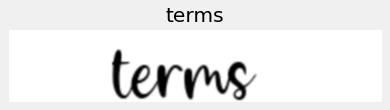

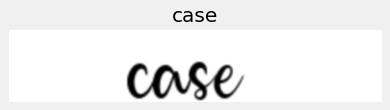



5 random images from the validation set:


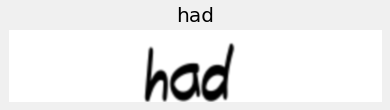

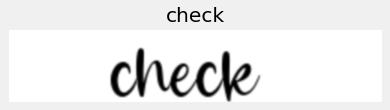

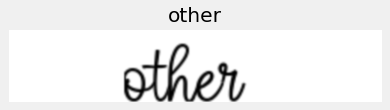

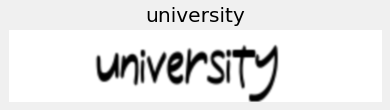

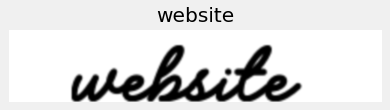



5 random images from the test set:


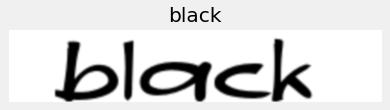

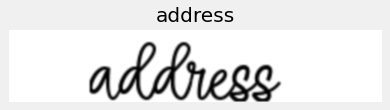

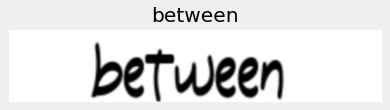

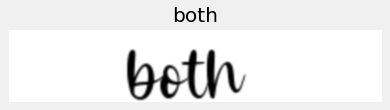

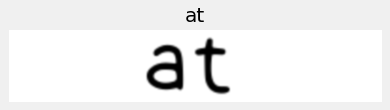



Number of word classes present in train set: 300

Number of word classes present in validation set: 86

Number of word classes present in test set: 198


In [5]:
# Insert code to build a dataframe with Images and their corresponding labels for 3 folders (similar to Lab 3(a))
def get_dataframe(folder_name):
  files = os.walk(folder_name)
  temp_list = []
  for path, subdirs, file in files:
      temp_list.append(file)

  all_files = [] #stores the filename of everyfile
  for temp_l in temp_list:
      for filename in temp_l:
          all_files.append(filename)

  """stores the filenames like: are, american, etc."""
  filenames = []
  for f in all_files:
      filename = os.path.splitext(f)[0].split('_')[0]
      filenames.append(filename)

  data = {
      'Image' : all_files,
      'Labels' : filenames,
  }

  df = pd.DataFrame(data, columns = ['Image', 'Labels'])

  return df

# display the dataframes
df_train = get_dataframe(train_dir_path)
df_validation = get_dataframe(validation_dir_path)
df_test = get_dataframe(test_dir_path)

print('dataframe for training set:') 
print(df_train)
print('\ndataframe for validation set:')
print(df_validation)
print('\ndataframe for test set:')
print(df_test)


# function to visualise images from a given set
def visualise_image(directory, df, last_row):
  """function to visualise images from a given set"""
  count = 1
  plt.style.use('fivethirtyeight')
  while count <= 5:
    num = random.randint(0,last_row)
    img_name = df['Image'][num]
    img = cv2.imread(directory + img_name,0)
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.title(df['Labels'][num])
    plt.show()
    print('\n')
    count += 1

# Visualise images from the train set
print('\n5 random images from the train set:')
visualise_image(train_dir_path, df_train, df_train.shape[0] - 1)

# Visualise images from the validation set
print('5 random images from the validation set:')
visualise_image(validation_dir_path, df_validation, df_validation.shape[0] - 1)

# Visualise images from the test set
print('5 random images from the test set:')
visualise_image(test_dir_path, df_test, df_validation.shape[0] - 1)

#code to get the number of word classes present in each set
def get_word_classes(df):
  """function to get the number of word classes present in each set"""
  dict_labels = {} 
  file_labels = [i for i in df['Labels']]
  for label in file_labels:
    if label not in dict_labels:
      dict_labels.update({label:1})
    else:
      dict_labels[label] += 1
  return len(dict_labels)


print(f'Number of word classes present in train set: {get_word_classes(df_train)}\n')
print(f'Number of word classes present in validation set: {get_word_classes(df_validation)}\n')
print(f'Number of word classes present in test set: {get_word_classes(df_test)}')

Now, you will have to write modules that can give you vector representations for the input words.


In [6]:
def splitter(str):
  """this function will generate all the possible permutations of a given string"""
  for i in range(1, len(str)):
      start = str[0:i]
      end = str[i:]
      yield (start, end)
      for split in splitter(end):
        result = [start]
        result.extend(split)
        yield result

def help_splitter(str, length):
  """helper function to use in the splitter function, this function takes a string and split the string into
     segment of nearly equal length"""

  if length > len(str):
    ans_list = [i for i in str]
    i = 0
    #print(ans_list)
    #print(len(ans_list))
    limit = length - len(ans_list)
    while i < limit:
      ans_list.insert(0,'')
      i += 1
    return ans_list

  combinations = list(splitter(str))
  #print(combinations)

  temp_list = [] #to store the lists having all the possible combinations of the given segments size
  for i in combinations:
    if len(i) == length: #you can vary this to get particular length size in the list temp_list
      temp_list.append(i)
  #print(temp_list)

  #to find the list which have minimum difference in lengths
  diff = 0 #variable to keep track the difference between the two consecutive segments
  comp = 100000 #some maximum number for comparison 
  ans_list = [] #to get the final list of segments
  for li in temp_list:
    for i in range(len(li)):
      if i+1 != len(li):
        res = len(li[i + 1]) - len(li[i]) #difference between two consecutive segments
        if res < 0:
          res = 0 - res
        diff += res
    #print(diff)
    if diff < comp: #if the current diff count is less than comp, then this list contains the segments with nearly equal length
      ans_list = li
      comp = diff
    diff = 0
  #print(ans_list) #priting the list 
  return ans_list 

ans = help_splitter('ok', 5)
print(ans)

['', '', '', 'o', 'k']


In [7]:
def print_dictionary(dictionary):
  """prints the content of a dictionary """
  for k, v in dictionary.items():
    print(f'{k} : {v}')

In [8]:
def get_Omega_vector(word):
  #Insert the code for a function that returns Omega representation of the input word

  dict_shapes = {} #dictionary to get the data of csv file which maps each character(a to z) to the list of shapes
  with open(csv_path, 'r') as data_file:
    reader = csv.reader(data_file, delimiter=',')
    for A, B, C, D, E, F, G, H, I, J, K, L in reader:
      dict_shapes.update({A: [B,C,D,E,F,G,H,I,J,K,L]})
  #print_dictionary(dict_shapes)

  #Hint: For computing count of segments, you can add count of shapes for individual characters (already provided in Alphabet.csv file)

  omega_list = [] #list of all vectors combined 
  for level in range(1, 6):
    temp_list = []
    temp_array = [0] * 11 #list of 11 integers initialized to 0
    #print(temp_array)
    if level == 1: #no need to call the help_splitter function here, the vector can be known directly from the dictionary
      #case when the given word itself is a complete segment, for each character add up the column values and put in a temp_list
      #later append this temp_list to the omega_list
      for char in word:
        for key, val in dict_shapes.items():
          if key == char:
            for i in range(11):
              temp_array[i] += int(val[i])
            #print(temp_array)
      for num in temp_array:
        omega_list.append(num) #appending the first 11 integers in omega_list for first level
    else: #if the level is not 1
      #call the help_splitter(word, level) here#it will return a list or a tuple
      #consider the first word from the list then second and so on until all are considered
      #if it is empty, then simply append 11 0's in the omega list
      #else if it is not empty then do the same thing as done for level 1
      seg_list = help_splitter(word, level)
      for seg in seg_list:
        if seg == '':
          for i in temp_array: #appends 11 0's to omega list
            omega_list.append(i)
        else:
          for char in seg:
            for key, val in dict_shapes.items():
              if key == char:
                for i in range(11):
                  temp_array[i] += int(val[i])
          for num in temp_array:
            omega_list.append(num)
          temp_array.clear()
          temp_array = [0] * 11 #for next segment of the word
      
  omega_list = np.array(omega_list)
  return omega_list

In [9]:
def get_Alpha_vector(word):
  #Insert the code for a function that returns Alpha representation of the input word 
  #TODO:
  alpha_list = [] #final list of the alpha representation
  for level in range(2, 6):
    seg_list = help_splitter(word, level)
    temp_list = [0] * 26 #appending 26 0's to the temp_list
    for seg in seg_list:
      for char in seg:
        index = 97 - ord(char)
        temp_list[index] += 1
      #print(temp_list)
      for num in temp_list:
        alpha_list.append(num)
      temp_list.clear()
      temp_list = [0] * 26 
  #print(len(alpha_list))
  alpha_list = np.array(alpha_list)
  return alpha_list

To test the above modules, try printing Omega and Alpha vectors for your first name.

In [10]:
name ="gagan"

print("Omega vector:",get_Omega_vector(name))

print("Alphavector:",get_Alpha_vector(name))

Omega vector: [0 2 4 0 0 0 4 6 0 0 0 0 1 2 0 0 0 2 2 0 0 0 0 1 2 0 0 0 2 4 0 0 0 0 1 1 0
 0 0 1 1 0 0 0 0 1 2 0 0 0 2 2 0 0 0 0 0 1 0 0 0 1 3 0 0 0 0 1 1 0 0 0 1 1
 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 3 0 0 0 0
 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
Alphavector: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 

# Building Alpha model architecture 

Following is the architecture of the model that will learn Alpha representation:

Input shape: 250 * 50 ( RGB )


* 2 Convolution layers with 64  filters
* A Max Pool layer with pool size 2 * 2   
* 2 Convolution layers with 128  filters
* A Max Pool layer with pool size 2 * 2    
* 6 Convolution layers with 256  filters
* 3 Convolution layers with 512  filters
* GLobal Average Pooling layer
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 364 units (Output)

For all convolution layers, keep kernel size as 3 * 3, use ReLu activation 

For all max pool layers, keep stride as 2

For all dense layers, except the final layer use ReLu activation.

For final layer, use sigmoid activation.

**Loss function**: Binary cross-entropy

**Similarity Metric**: Cosine Similarity

You need to make a function that will take a learning rate as parameter as return the compiled Alpha model.


In [11]:
#Insert the code for function that returns a model which will predict Alpharepresentation

def Alpha_model(learning_rate=1e-4):
    # Instantiate Sequential model
    model = tf.keras.models.Sequential()
    
    # Add Layers
    model.add(tf.keras.Input(shape=(250, 50, 3)))
    model.add(tf.keras.layers.Conv2D(64, (3,3), 3, activation="relu"))
    model.add(tf.keras.layers.Conv2D(64, (3,3), 3, activation="relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2))
    model.add(tf.keras.layers.Conv2D(128, (3,3), 3, activation="relu",padding="same"))
    model.add(tf.keras.layers.Conv2D(128, (3,3), 3, activation="relu",padding="same"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2,padding="same"))
    model.add(tf.keras.layers.Conv2D(256, (3,3), 3, activation="relu",padding="same"))
    model.add(tf.keras.layers.Conv2D(256, (3,3), 3, activation="relu",padding="same"))
    model.add(tf.keras.layers.Conv2D(256, (3,3), 3, activation="relu",padding="same"))
    model.add(tf.keras.layers.Conv2D(256, (3,3), 3, activation="relu",padding="same"))
    model.add(tf.keras.layers.Conv2D(256, (3,3), 3, activation="relu",padding="same"))
    model.add(tf.keras.layers.Conv2D(256, (3,3), 3, activation="relu",padding="same"))
    model.add(tf.keras.layers.Conv2D(512, (3,3), 3, activation="relu",padding="same"))
    model.add(tf.keras.layers.Conv2D(512, (3,3), 3, activation="relu",padding="same"))
    model.add(tf.keras.layers.Conv2D(512, (3,3), 3, activation="relu",padding="same"))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.Dense(364, activation='sigmoid'))

    # Define optimizers(Adam Optimizers), loss function and similarity metrics

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    cat_loss = tf.keras.losses.BinaryCrossentropy()
    acc_metrics = [tf.keras.metrics.CosineSimilarity()]
    
    
    # Compile the model
    
    model.compile(optimizer=opt, loss=cat_loss, metrics=acc_metrics)
    
    # return model

    return model
    

Following is the architecture of the Omega model, i.e. model that will learn to predict Omega representation:

Input shape: 250 * 50 ( RGB )


* 2 Convolution layers with 64  filters
* A Max Pool layer with pool size 2 * 2   
* 2 Convolution layers with 128  filters
* A Max Pool layer with pool size 2 * 2    
* 6 Convolution layers with 256  filters
* 3 Convolution layers with 512  filters
* GLobal Average Pooling layer
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 4096 units
* Dropout layer with rate 0.5
* Dense  layer with 165 units (Output)

For all convolution layers, keep kernel size as 3 * 3, use ReLu activation 

For all max pool layers, keep stride as 2

For all dense layers, use ReLu activation.

**Loss function**: Mean-squared error

**Similarity Metric**: Cosine Similarity

You need to make a function that will take a learning rate as parameter as return the compiled Omega model.


In [12]:
#Insert the code for function that returns a model which will predict Omega representation

def Omega_model(learning_rate=1e-4):
    # Instantiate Sequential model
    model = tf.keras.models.Sequential()
    
    # Add Layers
    model.add(tf.keras.Input(shape=(250, 50, 3)))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3),activation="relu"))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu"))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2))
    model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation="relu"))
    model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation="relu"))
    model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation="relu"))
    model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation="relu"))
    model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation="relu", padding='same'))
    model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation="relu",padding='same'))
    model.add(tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation="relu",padding='same'))
    model.add(tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation="relu",padding='same'))
    model.add(tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation="relu",padding='same'))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(units=4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.Dense(units=4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.Dense(units=165, activation='relu'))

    # Define optimizers (Adam Optimizer), loss function and similarity metrics
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    cat_loss = tf.keras.losses.mse
    acc_metrics = [tf.keras.metrics.CosineSimilarity()]
    
    
    # Compile the model
    
    model.compile(optimizer=opt, loss=cat_loss, metrics=acc_metrics)
    
    # return model
    
    return model

## Seen and Unseen Words

Words whose images hase been seen by the model during training are termed as seen words, while those which are part of the test set but not seen during training are called unseen words.


In [ ]:
#Insert code to print seen word classes 
print('seen words:\n')
df_train = get_dataframe(train_dir_path)
list_1 = set([i for i in df_train['Labels']])
for word in list_1:
  print(word)
#Insert code to print unseen word classes from test set
print('\nUnseen words:\n')
df_test = get_dataframe(test_dir_path)
list_1 = set([i for i in df_test['Labels']])
for word in list_1:
  print(word)

seen words:

available
part
have
just
web
were
search
car
now
f
number
real
de
are
about
o
own
its
buy
with
being
local
do
jan
been
must
reserved
life
university
sign
days
see
view
store
find
great
made
games
next
best
long
am
last
products
dvd
books
mail
uk
city
of
c
is
national
what
house
used
add
using
even
could
line
details
states
map
item
his
prices
who
like
reviews
day
hotels
a
date
email
music
post
page
because
n
items
please
year
both
state
on
go
terms
two
i
want
b
services
book
but
news
will
office
home
pm
work
many
shipping
only
site
member
them
good
website
from
or
management
high
program
how
price
very
way
also
development
service
special
technology
we
united
d
based
research
forum
much
s
women
need
contact
links
under
that
people
this
to
said
be
between
company
in
may
use
today
click
well
privacy
years
was
general
if
list
m
online
posted
ebay
all
file
free
set
results
up
rights
our
world
policy
product
show
w
phone
here
has
she
l
had
p
business
as
know
some
help
related
n

In [13]:
NUM_EPOCHS=30
BATCH_SIZE=8

# Tuning Hyperparameters for Omega Model
We will now tune the *learning rate* for the first model. 
For that, load the train and validation data (images and their labels, i.e. Omega vectors) 



In [14]:
#Insert the code for loading train and validation set images and their corresponding labels 
df_train = get_dataframe(train_dir_path)
#print(df_train)
df_validation = get_dataframe(validation_dir_path)
#print(df_validation)


def read_img_from_dir(directory):
  img = cv2.imread(directory)
  return img

d_train_img = []
d_train_Labels = []
d_validate_img = []
d_validate_Labels = []

for name in df_train.Image:
    d_train_img.append((read_img_from_dir(train_dir_path + name)))
    
for label in df_train.Labels:
    d_train_Labels.append(get_Omega_vector(label))
    
for name in df_validation.Image:
    d_validate_img.append((read_img_from_dir(validation_dir_path + name)))
    
for label in df_validation.Labels:
    d_validate_Labels.append(get_Omega_vector(label)) 
    
d_train_img=np.array(d_train_img)
d_train_img=d_train_img.reshape(-1,250,50,3)

d_train_Labels=np.array(d_train_Labels)

d_validate_img=np.array(d_validate_img)
d_validate_img=d_validate_img.reshape(-1,250,50,3)

d_validate_Labels = np.array(d_validate_Labels)




Now find the best LR for the Omega model.


In [ ]:
def determine_Omega_lr():
    learning_rates = [1e-3,1e-4,1e-5]
    avg_val_similarity = []
    

    for l_rate in learning_rates:
        
        # Insert your code here to build a model with the current learning rate
        model = Omega_model(learning_rate=l_rate)
        
        # Insert your code here to train the model using the training set and validate using the validation set
        history = model.fit(x=d_train_img, y=d_train_Labels,epochs=NUM_EPOCHS, validation_data = (d_validate_img, d_validate_Labels),batch_size=BATCH_SIZE,verbose=2)
        
        # Insert your code here to find the average validation accuracy for this model setting and append it to the maintained list
        similarity = np.mean(history.history['val_cosine_similarity'])
        avg_val_similarity.append(similarity)


    # Insert your code here to figure out the learning rate which gives the highest average validation accuracy. Print the value and return it.
    max_validation = 0
    best_lr = 0
    for i in range(len(learning_rates)):
      if avg_val_similarity[i] > max_validation:
        max_validation = avg_val_similarity[i]
        best_lr = learning_rates[i]
    print(f'\nBest learning rate: {best_lr}')
    return best_lr


# determine_best_learning_rate() is being called here
best_Omega_lr = determine_Omega_lr()

65/65 - 491s - loss: 48.2163 - cosine_similarity: 0.3840 - val_loss: 0.4640 - val_cosine_similarity: 0.4166
65/65 - 490s - loss: 0.3259 - cosine_similarity: 0.6662 - val_loss: 0.2792 - val_cosine_similarity: 0.7252
65/65 - 489s - loss: 0.3965 - cosine_similarity: 0.5657 - val_loss: 0.2804 - val_cosine_similarity: 0.7154

Best learning rate: 0.0001


# Tuning Hyperparameters for Alpha Model
We will now tune the *learning rate* for the second model. 

For that, load the train and validation data (images and their labels, i.e. Alpha vectors) 


In [15]:
#Insert the code for loading train and validation set images and their corresponding labels (1 point)

#Insert the code for loading train and validation set images and their corresponding labels 
df_train = get_dataframe(train_dir_path)
#print(df_train)
df_validation = get_dataframe(validation_dir_path)
#print(df_validation)


def read_img_from_dir(directory):
  img = cv2.imread(directory)
  return img

df_train_img = []
df_train_Labels = []
df_validate_img = []
df_validate_Labels = []

for name in df_train.Image:
    df_train_img.append((read_img_from_dir(train_dir_path + name)))
    
for label in df_train.Labels:
    df_train_Labels.append(get_Alpha_vector(label))
    
for name in df_validation.Image:
    df_validate_img.append((read_img_from_dir(validation_dir_path + name)))
    
for label in df_validation.Labels:
    df_validate_Labels.append(get_Alpha_vector(label)) 
    
df_train_img=np.array(df_train_img)
df_train_img=df_train_img.reshape(-1,250,50,3)

df_train_Labels=np.array(df_train_Labels)

df_validate_img=np.array(df_validate_img)
df_validate_img=df_validate_img.reshape(-1,250,50,3)

df_validate_Labels = np.array(df_validate_Labels)



Now find the best LR for the Omega model.


In [ ]:
def determine_Alpha_lr():
    learning_rates = [1e-3,1e-4,1e-5]
    avg_val_similarity = []
    

    for l_rate in learning_rates:
        
        # Insert your code here to build a model with the current learning rate
        model = Alpha_model(learning_rate=l_rate)
        
        # Insert your code here to train the model using the training set and validate using the validation set
        history = model.fit(x=df_train_img,y=df_train_Labels,epochs= NUM_EPOCHS, validation_data= (df_validate_img, df_validate_Labels),batch_size=BATCH_SIZE, verbose=2)
        
        # Insert your code here to find the average validation similarity for this model setting and append it to the maintained list
        similarity = np.mean(history.history['val_cosine_similarity'])
        avg_val_similarity.append(similarity)
    # Insert your code here to figure out the learning rate which gives the highest average validation similarity. Print the value and return it.
    max_similarity = 0
    best_lr = 0
    for i in range(len(learning_rates)):
      if avg_val_similarity[i] > max_similarity:
        max_similarity = avg_val_similarity[i]
        best_lr = learning_rates[i]
    print(f'\nBest learning rate: {best_lr}')
    return best_lr


# determine_best_learning_rate() is being called here
best_Alpha_lr = determine_Alpha_lr()

65/65 - 76s - loss: 0.2451 - cosine_similarity: 0.2830 - val_loss: 0.1664 - val_cosine_similarity: 0.2920
65/65 - 75s - loss: 0.4873 - cosine_similarity: 0.2360 - val_loss: 0.1756 - val_cosine_similarity: 0.2602
65/65 - 71s - loss: 0.6926 - cosine_similarity: 0.2130 - val_loss: 0.6916 - val_cosine_similarity: 0.2067

Best learning rate: 0.001


---

 The purpose and arguments of following callbacks from `tensorflow.keras.callbacks`


1. EarlyStopping()

> * ___monitor___ : It specifies the quantity which is to be monitored.
* ___min_delta___:	Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
* ___patience___: it specifies the number of epochs with no improvement after which training will be stopped.
* ___verbose___ : verbosity mode.</br>
* ___mode___ :  	One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
* ___baseline___: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
* ___restore_best_weights___: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used. 

2. ReduceLROnPlateau() 

> * ___monitor___: quantity to be monitored.
* ___factor___: factor by which the learning rate will be reduced. new_lr = lr * factor.
* ___patience___: number of epochs with no improvement after which learning rate will be reduced.
* ___verbose___ : int. 0: quiet, 1: update messages.
* ___mode___ :	one of {'auto', 'min', 'max'}. In 'min' mode, the learning rate will be reduced when the quantity monitored has stopped decreasing; in 'max' mode it will be reduced when the quantity monitored has stopped increasing; in 'auto' mode, the direction is automatically inferred from the name of the monitored quantity.
* ___min_delta___ : threshold for measuring the new optimum, to only focus on significant changes.
* ___cooldown___ : number of epochs to wait before resuming normal operation after lr has been reduced.
* ___min_lr___:	lower bound on the learning rate. 

3. CSVLogger() 

> * ___filename___ : Filename of the CSV file, e.g. 'run/log.csv'.
* ___separator___: String used to separate elements in the CSV file.
* ___append___ : Boolean. True: append if file exists (useful for continuing training). False: overwrite existing file. 


4. ModelCheckPoint() 

> * ___filepath___ : string or PathLike, path to save the model file. filepath can contain named formatting options, which will be filled the value of epoch and keys in logs (passed in on_epoch_end). For example: if filepath is weights.{epoch:02d}-{val_loss:.2f}.hdf5, then the model checkpoints will be saved with the epoch number and the validation loss in the filename.
* ___monitor___: The metric name to monitor. Typically the metrics are set by the Model.compile method.
* ___verbose___: verbosity mode, 0 or 1.
* ___save_best_only___ : if save_best_only=True, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten. If filepath doesn't contain formatting options like {epoch} then filepath will be overwritten by each new better model.
* ___mode___: one of {'auto', 'min', 'max'}. If save_best_only=True, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min, etc. In auto mode, the direction is automatically inferred from the name of the monitored quantity.
* ___save_weights_only___ :if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).
* ___save_freq___ :'epoch' or integer. When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches. If the Model is compiled with steps_per_execution=N, then the saving criteria will be checked every Nth batch.  Defaults to 'epoch'.
* ___options___ : Optional tf.train.CheckpointOptions object if save_weights_only is true or optional tf.saved_model.SaveOptions object if save_weights_only is false.
* ___**kwargs___: Additional arguments for backwards compatibility. Possible key is period.




# Model building and training using callbacks

---
Now build and summarize the Omega model as per the best learning rate value determined earlier.




In [ ]:
# Insert code for building model using the best LR determined
model = Omega_model(1e-3)

model.summary()


Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_569 (Conv2D)          (None, 248, 48, 64)       1792      
_________________________________________________________________
conv2d_570 (Conv2D)          (None, 246, 46, 64)       36928     
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 123, 23, 64)       0         
_________________________________________________________________
conv2d_571 (Conv2D)          (None, 121, 21, 128)      73856     
_________________________________________________________________
conv2d_572 (Conv2D)          (None, 119, 19, 128)      147584    
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 59, 9, 128)        0         
_________________________________________________________________
conv2d_573 (Conv2D)          (None, 57, 7, 256)      

Now instantiate the four callbacks which you have described above.


In [ ]:

# EarlyStopping after validation loss has not improved for 5 epochs 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='auto')

# ReduceLROnPlateau reducing LR by half when validation loss has not improved for 3 epochs. 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3)

# CSVlogger for keeping logs in filename of your choice
csv_logger = tf.keras.callbacks.CSVLogger('training.log')

# ModelCheckpoint that saves the best weights of model after every 10 epochs
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="drive/MyDrive/wr-dataset/WR-Dataset/",
    monitor='val_loss',
    save_weights_only=True,
    save_freq= 10,
    save_best_only=True)


# Make a list of all the callbacks
CB = [callback, reduce_lr, csv_logger, model_checkpoint_callback]


Now train the model using these callbacks for the loaded training word images.


Epoch 1/30
257/257 [==============================] - 483s 2s/step - loss: 18.1896 - cosine_similarity: 0.4917 - val_loss: 0.3019 - val_cosine_similarity: 0.7037
Epoch 2/30
257/257 [==============================] - 480s 2s/step - loss: 0.3210 - cosine_similarity: 0.6842 - val_loss: 0.2982 - val_cosine_similarity: 0.7086
Epoch 3/30
257/257 [==============================] - 470s 2s/step - loss: 0.3105 - cosine_similarity: 0.6959 - val_loss: 0.2971 - val_cosine_similarity: 0.7080
Epoch 4/30
257/257 [==============================] - 468s 2s/step - loss: 0.3167 - cosine_similarity: 0.6909 - val_loss: 0.2951 - val_cosine_similarity: 0.7114
Epoch 5/30
257/257 [==============================] - 466s 2s/step - loss: 0.3038 - cosine_similarity: 0.6914 - val_loss: 0.2958 - val_cosine_similarity: 0.7095
Epoch 6/30
257/257 [==============================] - 476s 2s/step - loss: 0.3112 - cosine_similarity: 0.6958 - val_loss: 0.2968 - val_cosine_similarity: 0.7104
Epoch 7/30
257/257 [=============

ValueError: ignored

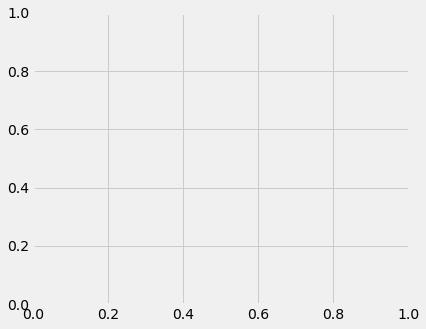

In [ ]:
# Insert code to train with callbacks (2 points)
model = Omega_model(1e-3)
history = model.fit(x=d_train_img,y=d_train_Labels, epochs = NUM_EPOCHS, validation_data=(d_validate_img,d_validate_Labels),batch_size= BATCH_SIZE, callbacks=CB)

# Insert your code here to obtain the lists: epochs, training similarity, validation similarity, training loss, validation loss from CSV log file (1 point)
epochs = range(1, NUM_EPOCHS + 1)
training_similarity = history.history['cosine_similarity']
validation_similarity = history.history['val_cosine_similarity']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']



# Insert your code here to plot Epochs Vs. training and validation similarity (2 points)
fig= plt.figure(figsize=(6,5))
plt.plot(epochs, training_similarity, 'g', label='Training similarity')
plt.plot(epochs, validation_similarity, 'b', label='Validation similarity')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




# Insert your code here to plot Epochs Vs. training and validation loss (2 points)
print('\n')
fig= plt.figure(figsize=(6,5))
plt.plot(epochs, training_loss, 'g', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



Now build and summarize the Alpha model as per the best learning rate value determined earlier. 



In [ ]:
# Insert code for building model using the best LR for Alpha model determined
model = Alpha_model(1e-3)

model.summary()

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_582 (Conv2D)          (None, 83, 16, 64)        1792      
_________________________________________________________________
conv2d_583 (Conv2D)          (None, 27, 5, 64)         36928     
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 13, 2, 64)         0         
_________________________________________________________________
conv2d_584 (Conv2D)          (None, 5, 1, 128)         73856     
_________________________________________________________________
conv2d_585 (Conv2D)          (None, 2, 1, 128)         147584    
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_586 (Conv2D)          (None, 1, 1, 256)       

Now instantiate the four callbacks for Alpha model.


In [16]:
# EarlyStopping after validation loss has not improved for 5 epochs 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# ReduceLROnPlateau reducing LR by half when validation loss has not improved for 3 epochs. 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3)

# CSVlogger for keeping logs in filename of your choice
csv_logger = tf.keras.callbacks.CSVLogger('training2.log')

# ModelCheckpoint that saves the best weights of model after every 10 epochs
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="drive/MyDrive/wr-dataset/WR-Dataset/",
    monitor='val_cosine_similarity',
    save_weights_only=True,
    mode='max',
    save_freq= 10,
    save_best_only=True)

CB = [callback, reduce_lr, csv_logger, model_checkpoint_callback]

Now train the model with training data using these callbacks.


Epoch 1/30
257/257 - 111s - loss: 0.1911 - cosine_similarity: 0.2969 - val_loss: 0.1668 - val_cosine_similarity: 0.2938
Epoch 2/30
257/257 - 107s - loss: 0.1712 - cosine_similarity: 0.3059 - val_loss: 0.1638 - val_cosine_similarity: 0.2929
Epoch 3/30
257/257 - 108s - loss: 0.1686 - cosine_similarity: 0.3094 - val_loss: 0.1617 - val_cosine_similarity: 0.2944
Epoch 4/30
257/257 - 110s - loss: 0.1670 - cosine_similarity: 0.3136 - val_loss: 0.1614 - val_cosine_similarity: 0.2946
Epoch 5/30
257/257 - 110s - loss: 0.1655 - cosine_similarity: 0.3161 - val_loss: 0.1603 - val_cosine_similarity: 0.2996
Epoch 6/30
257/257 - 110s - loss: 0.1639 - cosine_similarity: 0.3208 - val_loss: 0.1589 - val_cosine_similarity: 0.3028
Epoch 7/30
257/257 - 110s - loss: 0.1628 - cosine_similarity: 0.3240 - val_loss: 0.1575 - val_cosine_similarity: 0.2984
Epoch 8/30
257/257 - 107s - loss: 0.1617 - cosine_similarity: 0.3262 - val_loss: 0.1575 - val_cosine_similarity: 0.3109
Epoch 9/30
257/257 - 108s - loss: 0.1610

ValueError: ignored

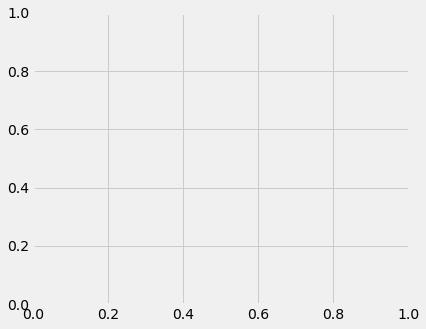

In [17]:
# Insert code to train with callbacks (2 points)
model = Alpha_model(1e-3)
history = model.fit(x=df_train_img,y=df_train_Labels,epochs= NUM_EPOCHS, validation_data= (df_validate_img, df_validate_Labels),batch_size=BATCH_SIZE, verbose=2, callbacks=CB)

# Insert your code here to obtain the lists: epochs, training similarity, validation similarity, training loss, validation loss from CSV log file (1 point)

epochs = range(1, NUM_EPOCHS + 1)
training_similarity = history.history['cosine_similarity']
validation_similarity = history.history['val_cosine_similarity']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']



# Insert your code here to plot Epochs Vs. training and validation accuracy (2 points)

fig= plt.figure(figsize=(6,5))
plt.plot(epochs, training_similarity, 'g', label='Training similarity')
plt.plot(epochs, validation_similarity, 'b', label='Validation similarity')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Insert your code here to plot Epochs Vs. training and validation loss (2 points)

print('\n')
fig= plt.figure(figsize=(6,5))
plt.plot(epochs, training_loss, 'g', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Steps for Word recognition:

First, prepare a list having all the words from test set mapped to their corresponding vectors (lexicon for both Omega and Alpha representations).

In [ ]:
df_test = get_dataframe(test_dir_path)

dict_test = {}
for label in df_test.Labels:
    dict_test.update({label:(get_Omega_vector(label), get_Alpha_vector(label))})

"""print_dictionary(dict_test)"""
print(list(dict_test.items()))


For every image in the test set:
1. Predict the output vector representation from the trained model(s) when the image is given as input.
2. Find the word class(from lexicon) for which the similarity of its vector representation will be highest with the output vector.
3. If predicted word = true word, then it is a correct prediction, otherwise incorrect prediction.

---

Let us now perform recognition using trained Alph amodel on the test set. 

First, load the test images and their vector representations.



In [ ]:
# Insert code to load test images and its vector labels (1 points)
def read_img_from_dir(directory):
  img = cv2.imread(directory)
  return img

df_test = get_dataframe(test_dir_path)

df_test_img = []
df_test_Labels = []

for name in df_test.Image:
    df_test_img.append((read_img_from_dir(test_dir_path + name)))
    
for label in df_test.Labels:
    df_test_Labels.append(get_Alpha_vector(label))

df_test_img=np.array(df_test_img)
df_test_img=df_test_img.reshape(-1,250,50,3)


Now load the saved trained Alpha model from the file and predict the labels


In [ ]:
# Insert code for loading the saved model from file 

model = load_model(filepath="drive/MyDrive/wr-dataset/WR-Dataset/", compile = True)

In [ ]:
# Insert code for predicting word labels of the test set images 

predictions = model.predict(df_test_img)

Let us evaluate the performance of the model. The effective accuracy of model is defined as harmonic mean(HM) of accuracy with seen class images and accuracy with unseen class images.


In [ ]:
# Insert code to compute accuracy of images that belong to seen classes 
score = model.evaluate(df_train_img, df_train_lab, verbose=0)
seen_acc = score[1]

# Insert code to compute accuracy of images that belong to unseen classes
score = model.evaluate(df_test_img, df_test_lab, verbose=0)
unseen_acc = score[1]

# Insert code to compute effective accuracy
acc = [seen_acc, unseen_acc]

eff_acc = statistics.harmonic_mean(acc)

print(f'effective accuracy: {eff_acc}')

Let us now perform recognition using trained Alpha model on the test set.
 
First, load the test images and their Omega vector representations.


In [ ]:
# Insert code to load test images and its vector labels
def read_img_from_dir(directory):
  img = cv2.imread(directory)
  return img

d_test = get_dataframe(test_dir_path)

d_test_img = []
d_test_Labels = []

for name in d_test.Image:
    d_test_img.append((read_img_from_dir(test_dir_path + name)))
    
for label in d_test.Labels:
    d_test_Labels.append(get_Omega_vector(label))

d_test_img=np.array(d_test_img)
d_test_img=d_test_img.reshape(-1,250,50,3)



Now load the saved trained Omega model from the file and predict the labels


In [ ]:
# Insert code for loading the saved model from file
model = load_model(filepath="drive/MyDrive/wr-dataset/WR-Dataset/", compile = True)


In [ ]:
# Insert code for predicting word labels of the test set images

predictions = model.predict(df_test_img)

Evaluate the performance of the Omega model


In [ ]:
# Insert code to compute accuracy of images that belong to seen classes

score = model.evaluate(d_train_img, d_train_lab, verbose=0)
seen_acc = score[1]



# Insert code to compute accuracy of images that belong to unseen classes
score = model.evaluate(d_test_img, d_test_lab, verbose=0)
unseen_acc = score[1]



# Insert code to compute effective accuracy

acc = [seen_acc, unseen_acc]

eff_acc = statistics.harmonic_mean(acc)

print(f'effective accuracy: {eff_acc}')
